# Visualization

## 5.1 Raw data 

### 5.1.1 Raw data time distribution

Generating Figure 1: Daily Time-of-Day Demand Distribution Chart (Color Updated) 

 Chart saved as: figure_1_hourly_demand_distribution_color_update.png


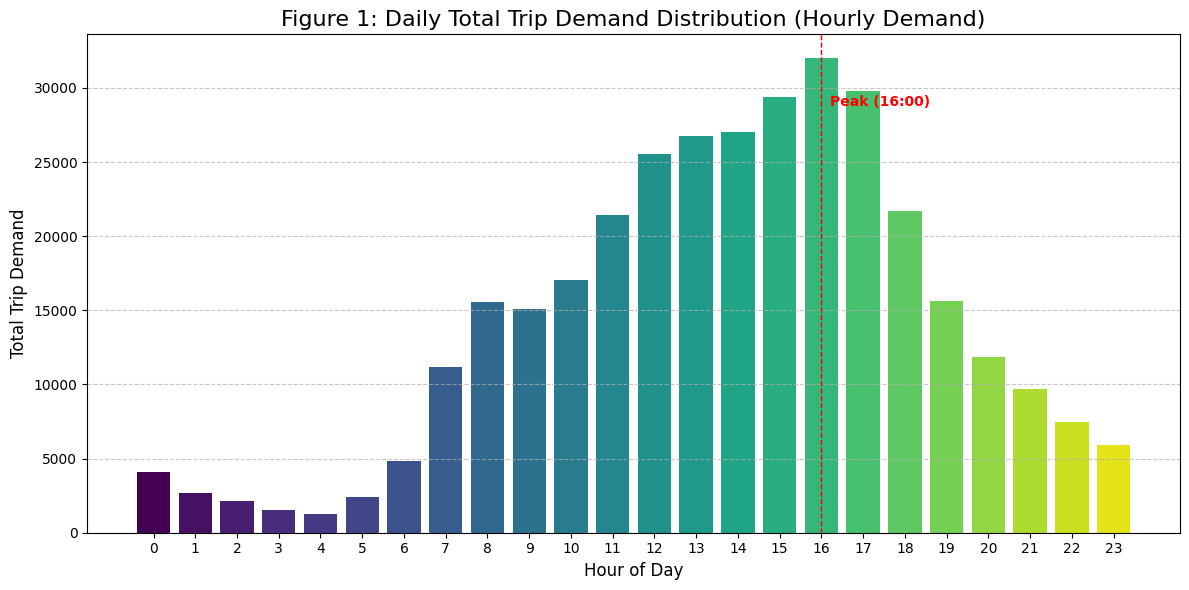

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm 

# Load the OD data
df_demand = pd.read_csv("od.csv")



def plot_hourly_demand(df):
    """Generates the bar chart showing demand variation over the 24 hours."""
    
    # Aggregation: Sum trips by hour
    hourly_demand = df.groupby('hour')['trips'].sum().reset_index()
    
    # Find peak demand hour
    peak_hour = hourly_demand.loc[hourly_demand['trips'].idxmax()]
    
    plt.figure(figsize=(12, 6))
    
    # Draw the bar chart with a colormap applied based on the hour value
    # Viridis is used to create a gradient effect
    plt.bar(
        hourly_demand['hour'],
        hourly_demand['trips'],
        color=cm.viridis(hourly_demand['hour'] / 24) 
    )
    
    # Annotate peak hour
    plt.axvline(x=peak_hour['hour'], color='red', linestyle='--', linewidth=1)
    plt.text(
        peak_hour['hour'] + 0.2, 
        peak_hour['trips'] * 0.9, 
        f'Peak ({int(peak_hour["hour"]):02d}:00)', 
        color='red', 
        fontsize=10, 
        weight='bold'
    )
    
    # Set chart title and labels
    plt.title('Figure 1: Daily Total Trip Demand Distribution (Hourly Demand)', fontsize=16)
    plt.xlabel('Hour of Day', fontsize=12)
    plt.ylabel('Total Trip Demand', fontsize=12)
    
    # Set X-axis ticks, displaying 0 to 23 hours
    plt.xticks(range(0, 24)) 
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # Save and display the chart
    filename = 'figure_1_hourly_demand_distribution_color_update.png'
    plt.savefig(filename)
    print(f"\n Chart saved as: {filename}")
    # plt.show()
    
print("Generating Figure 1: Daily Time-of-Day Demand Distribution Chart (Color Updated) ")
plot_hourly_demand(df_demand)

### 5.1.2 Raw data distribution in map

In [2]:
import pandas as pd
import numpy as np
import folium
import os
from folium.plugins import MarkerCluster




STATION_TASKS_FILE = "station_tasks.csv"


DEPOT_STATION_ID = '1019' 

OUTPUT_HTML_FILE = "station_demand_visualization_adjusted_legend.html"


BASE_RADIUS = 3 
RADIUS_SCALE_FACTOR = 2 



demand_df = pd.read_csv(STATION_TASKS_FILE)
    

demand_df['station_id'] = demand_df['station_id'].astype(str)
demand_df['latitude'] = demand_df['latitude'].astype(float)
demand_df['longitude'] = demand_df['longitude'].astype(float)
    

if 'net' in demand_df.columns:
    demand_df['net_need'] = demand_df['net'].astype(float)
else:
    raise ValueError("The CSV file is missing the 'net' demand column.")


if DEPOT_STATION_ID not in demand_df['station_id'].values:
    center_lat_lon = [demand_df['latitude'].mean(), demand_df['longitude'].mean()]
else:
    depot_data = demand_df[demand_df['station_id'] == DEPOT_STATION_ID].iloc[0]
    center_lat_lon = [depot_data['latitude'], depot_data['longitude']]



 
m = folium.Map(location=center_lat_lon, zoom_start=12, 
               tiles='OpenStreetMap', name='OpenStreetMap Basemap')

folium.TileLayer('CartoDB dark_matter', name='Dark Basemap').add_to(m)

demand_group = folium.FeatureGroup(name='All Station Demands', show=True).add_to(m)

for index, row in demand_df.iterrows():
    station_id = row['station_id']
    net_need = row['net_need'] 
    lat_lon = [row['latitude'], row['longitude']]
    
    # Popup content
    popup_content = (
        f"<b>Station ID: {station_id}</b><br>"
        f"Initial Stock: {row.get('initial_stock', 'N/A')}<br>"
        f"Capacity: {row.get('capacity', 'N/A')}<br>"
        f"Net Need (net): {net_need:.1f}<br>" 
        f"Move Out: {row.get('move_out', 'N/A')}<br>"
        f"Move In: {row.get('move_in', 'N/A')}"
    )
    
    
    if station_id == DEPOT_STATION_ID:
        # Depot station
        folium.Marker(
            lat_lon,
            popup=f'<b>Depot Station: {station_id}</b>',
            icon=folium.Icon(color='red', icon='home', prefix='fa')
        ).add_to(demand_group)
        
    elif net_need > 0.01: 
        # RED: Net Removal (Pickup)
        fill_color = 'Red'
        radius = BASE_RADIUS + net_need * RADIUS_SCALE_FACTOR
        
        folium.CircleMarker(
            location=lat_lon, radius=radius, color=fill_color, weight=1, fill=True,
            fill_color=fill_color, fill_opacity=0.7, 
            popup=f'**Pickup Point (Net Need: {net_need:.1f})**<br>{popup_content}'
        ).add_to(demand_group)
        
    elif net_need < -0.01: 
        # GREEN: Net Addition (Drop-off)
        fill_color = 'Green'
        radius = BASE_RADIUS + abs(net_need) * RADIUS_SCALE_FACTOR
        
        folium.CircleMarker(
            location=lat_lon, radius=radius, color=fill_color, weight=1, fill=True,
            fill_color=fill_color, fill_opacity=0.7, 
            popup=f'**Drop-off Point (Net Need: {abs(net_need):.1f})**<br>{popup_content}'
        ).add_to(demand_group)
        
    else: 
        # GRAY: Balanced or near-zero demand.
        fill_color = 'Gray'
        radius = BASE_RADIUS 
        
        folium.CircleMarker(
            location=lat_lon, radius=radius, color=fill_color, weight=1, fill=True,
            fill_color=fill_color, fill_opacity=0.5, 
            popup=f'Balanced Point<br>{popup_content}'
        ).add_to(demand_group)



BASE_RADIUS = 3 
RADIUS_SCALE_FACTOR = 2 


BASE_RADIUS = 3 
RADIUS_SCALE_FACTOR = 2 

legend_html = f'''
    <div style="position: fixed; 
                top: 50px; left: 50px; 
                width: 300px; height: 270px; 
                border:2px solid grey; z-index:9999; font-size:16px; 
                background-color: white; opacity: 0.9;">
      <h4 style="margin: 8px 8px 0 8px;">Demand Visualization Legend</h4>
      <p style="margin: 5px 8px 0 8px;"><b>Color Code (Net Need)</b></p>
      <ul style="list-style-type: none; padding-left: 10px; margin-top: 5px; margin-bottom: 5px;">
          <li><span style="color:red; font-size: 20px;">&#9679;</span> <b>RED: Net Removal</b> (Need pickup, Net > 0)</li>
          <li><span style="color:green; font-size: 20px;">&#9679;</span> <b>GREEN: Net Addition</b> (Need dropoff, Net < 0)</li>
          <li><span style="color:gray; font-size: 20px;">&#9679;</span> <b>GRAY: Balanced</b> (Net ≈ 0)</li>
      </ul>
      <p style="margin: 5px 8px 0 8px;"><b>Radius Scaling</b></p>
      <p style="font-size: 14px; margin: 0 8px 8px 8px;">
          Radius = {BASE_RADIUS} + (|Net Need| × {RADIUS_SCALE_FACTOR})<br>
          <span style="font-weight: bold;">Larger circle = Higher absolute demand.</span>
      </p>
    </div>
'''



print(legend_html)


m.get_root().html.add_child(folium.Element(legend_html))



folium.LayerControl().add_to(m)
m.save(OUTPUT_HTML_FILE)

print(f"\n Result")
print(f"source: {STATION_TASKS_FILE}")
print(f"Map has been kept: {OUTPUT_HTML_FILE}")



    <div style="position: fixed; 
                top: 50px; left: 50px; 
                width: 300px; height: 270px; 
                border:2px solid grey; z-index:9999; font-size:16px; 
                background-color: white; opacity: 0.9;">
      <h4 style="margin: 8px 8px 0 8px;">Demand Visualization Legend</h4>
      <p style="margin: 5px 8px 0 8px;"><b>Color Code (Net Need)</b></p>
      <ul style="list-style-type: none; padding-left: 10px; margin-top: 5px; margin-bottom: 5px;">
          <li><span style="color:red; font-size: 20px;">&#9679;</span> <b>RED: Net Removal</b> (Need pickup, Net > 0)</li>
          <li><span style="color:green; font-size: 20px;">&#9679;</span> <b>GREEN: Net Addition</b> (Need dropoff, Net < 0)</li>
          <li><span style="color:gray; font-size: 20px;">&#9679;</span> <b>GRAY: Balanced</b> (Net ≈ 0)</li>
      </ul>
      <p style="margin: 5px 8px 0 8px;"><b>Radius Scaling</b></p>
      <p style="font-size: 14px; margin: 0 8px 8px 8px;">
         

## 5.2 Demand prediction

Successfully loaded file: od_hourly_zip_poisson_daytype_1.csv
Number of OD pairs with non-zero predicted demand: 212


/var/folders/37/c8t1zshs29x5t669m6kp50nm0000gn/T/ipykernel_56153/830100968.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='hour', y=DEMAND_COLUMN, data=hourly_demand, palette='viridis_r')


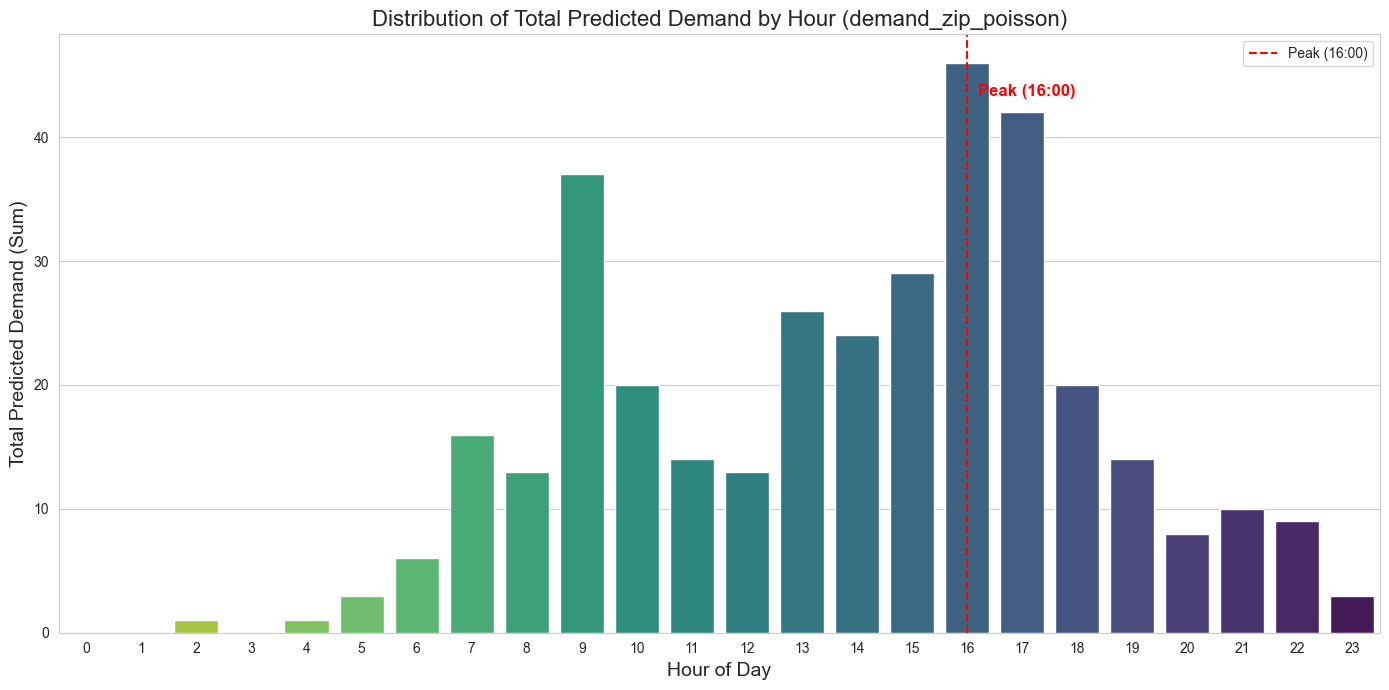

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# =========================================================================
# 0. File and Column Definitions
# =========================================================================

FILE_NAME = "od_hourly_zip_poisson_daytype_1.csv"
DEMAND_COLUMN = 'demand_zip_poisson'

# Set Matplotlib style
sns.set_style("whitegrid")
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica'] 
plt.rcParams['axes.unicode_minus'] = False 

# =========================================================================
# 1. Data Loading and Cleaning (Same as before)
# =========================================================================

try:
    df = pd.read_csv(FILE_NAME)
    print(f"Successfully loaded file: {FILE_NAME}")
    
    if 'hour' not in df.columns or DEMAND_COLUMN not in df.columns:
        raise ValueError(f"CSV file is missing required columns ('hour' or '{DEMAND_COLUMN}').")
        
    df[DEMAND_COLUMN] = pd.to_numeric(df[DEMAND_COLUMN], errors='coerce')
    df = df.dropna(subset=[DEMAND_COLUMN]).copy()
    
    df_non_zero = df[df[DEMAND_COLUMN] > 0].copy()
    print(f"Number of OD pairs with non-zero predicted demand: {len(df_non_zero)}")

except Exception as e:
    print(f"Data loading or processing failed: {e}")
    exit()

# =========================================================================
# 2. Visualization 1: Total Predicted Demand by Hour (Colormap and Peak)
# =========================================================================

# Aggregation: Calculate the sum of predicted demand for each hour
hourly_demand = df.groupby('hour')[DEMAND_COLUMN].sum().reset_index()

plt.figure(figsize=(14, 7)) # Slightly larger figure for better readability

# --- Using a colormap for gradient colors ---
# Using 'viridis_r' for a reverse viridis colormap to match the image's light-to-dark gradient
# Or 'crest' for a blue-green gradient, or 'mako' for a blue one
# I'll use `cmap='viridis_r'` and `palette='viridis_r'` for consistency
sns.barplot(x='hour', y=DEMAND_COLUMN, data=hourly_demand, palette='viridis_r') 

plt.title('Distribution of Total Predicted Demand by Hour (demand_zip_poisson)', fontsize=16)
plt.xlabel('Hour of Day', fontsize=14)
plt.ylabel('Total Predicted Demand (Sum)', fontsize=14)
plt.xticks(rotation=0)

# --- Add Peak Annotation and Vertical Line ---
peak_hour = hourly_demand.loc[hourly_demand[DEMAND_COLUMN].idxmax(), 'hour']
peak_demand = hourly_demand[DEMAND_COLUMN].max()

# Find the x-position for the peak hour bar (it's essentially the index in the x-axis)
# For a categorical plot, the x-values are 0, 1, 2... for categories
peak_x_position = hourly_demand['hour'].tolist().index(peak_hour)

# Add a vertical dashed line at the peak hour
plt.axvline(x=peak_x_position, color='red', linestyle='--', linewidth=1.5, label=f'Peak ({peak_hour}:00)')
# Add text annotation for the peak
plt.text(peak_x_position + 0.2, peak_demand * 0.95, f'Peak ({peak_hour}:00)', 
         color='red', ha='left', va='center', fontsize=12, fontweight='bold')

plt.legend() # Show the label for the peak line
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

# =========================================================================
# 3. Visualization 2: Demand Magnitude Distribution (Non-Zero Only)
#    (Keeping this plot with a single color, but you can also apply a colormap here if desired)
# =========================================================================

max_demand = df_non_zero[DEMAND_COLUMN].max()
bins = np.arange(0, 6, 1) 
labels = [f'{i}-{i+1}' for i in bins[:-1]]

if max_demand >= 5:
    bins = np.append(bins, max_demand + 1)
    labels.append(f'>{bins[-2]}')

df_non_zero['demand_bin'] = pd.cut(
    df_non_zero[DEMAND_COLUMN], 
    bins=bins, 
    labels=labels, 
    right=False,
    include_lowest=True
)

demand_magnitude_count = df_non_zero['demand_bin'].value_counts().sort_index()

plt.figure(figsize=(10, 6))


## 5.3 Result of capacity model

In [8]:
import pandas as pd
import folium

# Load the dataframe from the accessible file
df = pd.read_csv("station_tasks.csv")

# Ensure necessary columns are present and numeric
required_columns = ['latitude', 'longitude', 'initial_stock', 'capacity']
for col in required_columns:
    if col not in df.columns:
        raise ValueError(f"Missing required column: {col}")
    # Convert to numeric, coercing errors
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows with any NaN values in the required columns (e.g., failed conversion)
df.dropna(subset=required_columns, inplace=True)

# Calculate the mean latitude and longitude to center the map
center_lat = df['latitude'].mean()
center_lon = df['longitude'].mean()

# Initialize the map
m = folium.Map(location=[center_lat, center_lon], zoom_start=13)

# Define a function to determine marker color based on the ratio of initial_stock to capacity
def get_color(initial_stock, capacity):
    if capacity == 0:
        return 'gray'  # Handle division by zero
    ratio = initial_stock / capacity
    if ratio >= 0.75:
        return 'green'  # High stock
    elif ratio >= 0.25:
        return 'orange'  # Moderate stock
    else:
        return 'red'  # Low stock

# Add markers to the map
for index, row in df.iterrows():
    # Create the HTML popup content
    popup_html = f"""
    <h4>Station ID: {row['station_id']}</h4>
    <p><b>Initial Stock:</b> {int(row['initial_stock'])}</p>
    <p><b>Capacity:</b> {int(row['capacity'])}</p>
    """
    
    # Determine color
    color = get_color(row['initial_stock'], row['capacity'])
    
    # Create marker
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=folium.Popup(popup_html, max_width=300)
    ).add_to(m)

legend_html = '''
    <div style="position: fixed; 
                top: 20px; left: 20px; width: 260px; height: 220px; 
                border: 2px solid #333; border-radius: 8px; 
                background-color: white; opacity: 0.95; 
                z-index: 9999; font-family: Arial, sans-serif; font-size: 14px;">
        <h4 style="margin: 10px 0 8px 10px; color: #333; font-size: 16px;">Stock Level Legend</h4>
        <ul style="list-style: none; padding: 0 10px; margin: 0;">
            <li style="margin: 8px 0; display: flex; align-items: center;">
                <span style="display: inline-block; width: 15px; height: 15px; 
                             background-color: green; border-radius: 50%; 
                             margin-right: 10px; border: 1px solid #333;"></span>
                <span><b>Green:</b> High Stock (≥75% of Capacity)</span>
            </li>
            <li style="margin: 8px 0; display: flex; align-items: center;">
                <span style="display: inline-block; width: 15px; height: 15px; 
                             background-color: orange; border-radius: 50%; 
                             margin-right: 10px; border: 1px solid #333;"></span>
                <span><b>Orange:</b> Moderate Stock (25%-75% of Capacity)</span>
            </li>
            <li style="margin: 8px 0; display: flex; align-items: center;">
                <span style="display: inline-block; width: 15px; height: 15px; 
                             background-color: red; border-radius: 50%; 
                             margin-right: 10px; border: 1px solid #333;"></span>
                <span><b>Red:</b> Low Stock (<25% of Capacity)</span>
            </li>
            <li style="margin: 8px 0; display: flex; align-items: center;">
                <span style="display: inline-block; width: 15px; height: 15px; 
                             background-color: gray; border-radius: 50%; 
                             margin-right: 10px; border: 1px solid #333;"></span>
                <span><b>Gray:</b> Capacity = 0 (No Storage)</span>
            </li>
        </ul>
    </div>
'''
m.get_root().html.add_child(folium.Element(legend_html))

html_file_path = "station_stock_map.html"
m.save(html_file_path)

print(f"Map successfully generated and saved to {html_file_path}")


Map successfully generated and saved to station_stock_map.html


## 5.4 Route of rebanlancing

In [11]:
import pandas as pd
import numpy as np
import folium
import os



STATION_TASKS_FILE = "station_tasks.csv"

OPTIMAL_COST_Z2 = 184.55  
NUM_VEHICLES = 2          # vehicles
DEPOT_STATION_ID = '1019' # center ID 


#path
path_v1_str = "1019 -> 870 -> 265 -> 1763 -> 1024 -> 1808 -> 1747 -> 1807 -> 256 -> 1026 -> 820 -> 284 -> 1798 -> 877 -> 885 -> 1102 -> 355 -> 1038 -> 1743 -> 1745 -> 225 -> 251 -> 261 -> 1813 -> 1800 -> 1728 -> 356 -> 255 -> 1092 -> 340 -> 1093 -> 1769 -> 349 -> 264 -> 252 -> 1748 -> 1098 -> 1051 -> 351 -> 1823 -> 262 -> 247 -> 1025 -> 881 -> 275 -> 345 -> 1097 -> 1731 -> 1720 -> 1765 -> 1737 -> 1055 -> 1799 -> 1764 -> 1821 -> 290 -> 1756 -> 1859 -> 1860 -> 1822 -> 273 -> 1096 -> 189 -> 248 -> 285 -> 1730 -> 1818 -> 1028 -> 1824 -> 1052 -> 1721 -> 879 -> 1768 -> 253 -> 1744 -> 876 -> 183 -> 1019"
path_v2_str = "1019 -> 1090 -> 354 -> 352 -> 1766 -> 889 -> 342 -> 296 -> 1039 -> 2259 -> 358 -> 1738 -> 1767 -> 346 -> 343 -> 890 -> 1017 -> 171 -> 259 -> 249 -> 359 -> 1727 -> 2268 -> 289 -> 1726 -> 246 -> 344 -> 1757 -> 1050 -> 260 -> 1019"

# reorder OPTIMAL_ROUTES
OPTIMAL_ROUTES = [
    [str(node).strip() for node in path_v1_str.split('->')], # path of vehicle 1 
    [str(node).strip() for node in path_v2_str.split('->')]  # path of vehicle 2
]

OUTPUT_HTML_FILE = "vrp_new_path_map.html"

# =========================================================================
# 1. 数据加载和预处理 (使用 station_tasks.csv)
# =========================================================================


merged_df = pd.read_csv(STATION_TASKS_FILE)
merged_df['station_id'] = merged_df['station_id'].astype(str)
merged_df['latitude'] = merged_df['latitude'].astype(float)
merged_df['longitude'] = merged_df['longitude'].astype(float)
    
if 'net' in merged_df.columns:
    merged_df['net_need'] = merged_df['net'].astype(float)
 



all_route_ids = set()
for route in OPTIMAL_ROUTES:
    all_route_ids.update(route)
merged_df = merged_df[merged_df['station_id'].isin(all_route_ids)].copy()





#  Depot  [Latitude, Longitude]
depot_data = merged_df[merged_df['station_id'] == DEPOT_STATION_ID].iloc[0]
depot_lat_lon = [depot_data['latitude'], depot_data['longitude']]


m = folium.Map(location=depot_lat_lon, zoom_start=12, 
               tiles='OpenStreetMap', name='OpenStreetMap Basemap')

folium.TileLayer('CartoDB dark_matter', name='Dark Basemap').add_to(m)



depot_group = folium.FeatureGroup(name='Depot', show=True).add_to(m)
customer_group = folium.FeatureGroup(name='Customer Nodes', show=True).add_to(m)

for index, row in merged_df.iterrows():
    station_id = row['station_id']
    net_need = row['net_need'] 
    lat_lon = [row['latitude'], row['longitude']]
    
    
    popup_content = (
        f"<b>station ID: {station_id}</b><br>"
        f"initial stock: {row.get('initial_stock', 'N/A')}<br>"
        f"capacity: {row.get('capacity', 'N/A')}<br>"
        f"net demand: {net_need:.1f}<br>" 
        f"need to move out: {row.get('move_out', 'N/A')}<br>"
        f"need to move in: {row.get('move_in', 'N/A')}"
    )
    
    # def spot style
    if station_id == DEPOT_STATION_ID:
        icon_color = 'red'
        icon_type = 'home'
        
        folium.Marker(
            lat_lon,
            popup=f'<b>Depot: {station_id}</b><br> cost: {OPTIMAL_COST_Z2:.2f}',
            icon=folium.Icon(color=icon_color, icon=icon_type, prefix='fa')
        ).add_to(depot_group)
        
    elif net_need > 0.01: 
        fill_color = 'Red'
        radius = 8 + net_need * 2 
        
        folium.CircleMarker(
            location=lat_lon, radius=radius, color=fill_color, weight=1, fill=True,
            fill_color=fill_color, fill_opacity=0.7, popup=f'upload point<br>{popup_content}'
        ).add_to(customer_group)
        
    elif net_need < -0.01: 
        fill_color = 'Green'
        radius = 8 + abs(net_need) * 2 
        
        folium.CircleMarker(
            location=lat_lon, radius=radius, color=fill_color, weight=1, fill=True,
            fill_color=fill_color, fill_opacity=0.7, popup=f'download point<br>{popup_content}'
        ).add_to(customer_group)
        
    else: 
        fill_color = 'Gray'
        radius = 5
        
        folium.CircleMarker(
            location=lat_lon, radius=radius, color=fill_color, weight=1, fill=True,
            fill_color=fill_color, fill_opacity=0.5, popup=f'平衡点<br>{popup_content}'
        ).add_to(customer_group)


# painting route
colors_lines = ['blue', 'orange', 'purple', 'cyan', 'magenta', 'gold'] 

for k, route in enumerate(OPTIMAL_ROUTES):
    vehicle_idx = k + 1
    route_name = f'vechile {vehicle_idx} path'
    
    route_color = colors_lines[k % len(colors_lines)]
    group = folium.FeatureGroup(name=route_name, show=True).add_to(m)
    

    valid_route = [node for node in route if node in merged_df['station_id'].values]
    


    route_coords_df = merged_df[merged_df['station_id'].isin(valid_route)].set_index('station_id').loc[valid_route]
    route_lat_lons = route_coords_df[['latitude', 'longitude']].values.tolist()
    
    folium.PolyLine(
        route_lat_lons,
        color=route_color,
        weight=4,
        opacity=0.8,
        tooltip=route_name
    ).add_to(group)
    
    for lat, lon in route_lat_lons:
         folium.CircleMarker(
             location=[lat, lon],
             radius=3,
             color=route_color,
             fill=True,
             fill_color='white',
             fill_opacity=1.0
         ).add_to(group)


folium.LayerControl().add_to(m)


m.save(OUTPUT_HTML_FILE)
print(f"\n finished ")



 finished 
